In [1]:
import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

In [2]:
#First, let's define a "mean" function that we will add noise (and other stuff) to

#Working with sum of Lorentzians with reference widths changed based on T and P
def lorentzian(x, x0, w):
    numer = 0.5*w
    denom = (x - x0)**2 + (0.5*w)**2
    return (1.0/np.pi)*numer/denom


#Need to make the mean function a class that follows GPFlow's style
class MeanFunc(gpflow.mean_functions.MeanFunction):
    
    def __init__(self, locs=[-2.0, 0.0, 5.0], widths=[0.5, 1.0, 4.0]):
        self.locs = gpflow.Parameter(locs, dtype=tf.float64, name='lorentz_loc')
        self.widths = gpflow.Parameter(widths, dtype=tf.float64, name='lorentz_width',
                                       transform=gpflow.utilities.positive())

    def __call__(self, xTP):
        #First column is x, next is T, last is P
        xTP = tf.cast(xTP, tf.float64)
        x = xTP[:, :1]
        T = xTP[:, 1:2]
        P = xTP[:, 2:]
        widths = self.widths*tf.math.exp(-1.0/T)
        widths *= tf.math.exp(P)
        lineshapes = lorentzian(tf.reshape(x, (-1, 1)), self.locs, widths)
        line_sum = tf.reduce_sum(lineshapes, axis=1)
        return tf.reshape(line_sum, (-1, 1))


#Now we also need a noise/shift/extra stuff function, just for testing
def create_noise(x):
    rng = np.random.default_rng()
    min_x = np.min(x)
    max_x = np.max(x)
    shift = 0.1*(max_x - min_x) * rng.random()
    base = 0.5*np.sin((x + shift) * (2.0*np.pi/(max_x - min_x)))
    noise = rng.standard_normal(base.shape[0]) * 0.1 * abs(base)
    return base + noise



In the above, we've created a mean function that for our purposes here represents some fictitious lineshape model. to keep things simple, it's just a sum of three Lorentzians that get broadened with increasing temperature and pressure. This is not intended to be realistic, has some aspects that help illustrate the example. First, the mean function itself can be extremely complex, calling other functions and taking lots of different parameters. To work with GPFlow, we've inherited their mean function class and created the necessary methods. The one limitation is that the data for x, T, and P must come in a single array, where each input dimension is a column.

We've also create a function that generates some amount of random "noise" - it's not just noise, though, because it also adds in a baseline function (just a shifted, scaled sine function).

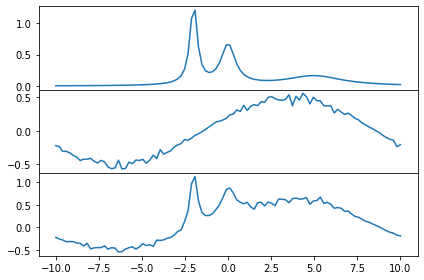

In [3]:
x = np.linspace(-10.0, 10.0, 100)
T = 1.0
P = 1.0
x_in = np.vstack([x, T*np.ones(x.shape[0]), P*np.ones(x.shape[0])]).T
mf = MeanFunc()

fig, ax = plt.subplots(3)
ax[0].plot(x, mf(x_in))
ax[1].plot(x, create_noise(x))
ax[2].plot(x, mf(x_in) + create_noise(x)[:, None])
fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

The top plots the underlying "lineshape" while the middle shows the added noise. In the bottom panel, we see the noise added to the lineshape to create input data. We will try and simultaneously fit our model and identify the noise at the same time.

In [4]:
#We need to create a kernel to use and a mean function
#Note that the parameters in the mean function defined here WILL BE MODIFIED by the fitting procedure
kern = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 1.0, 1.0])
mf_ref = MeanFunc()

#We want to generate data with columns of x, T, P and noise to go with it
x = np.linspace(-10.0, 10.0, 100)
temps = np.array([1.0, 0.1, 2.0])
pressures = np.array([1.0, 1.0, 0.5])
x_dat = []
noise = []
for i in range(temps.shape[0]):
    x_dat.append(np.vstack([x, temps[i]*np.ones(x.shape[0]), pressures[i]*np.ones(x.shape[0])]).T)
    noise.append(create_noise(x))
x_dat = np.vstack(x_dat)
#With x data, can just call the mean function (lazily letting initial parameters be the reference)
orig_y = mf_ref(x_dat)
orig_noise = np.hstack(noise)[:, None]
y_dat = orig_y + orig_noise

#Putting in parameters off from the true values for training
mf = MeanFunc(locs=[0.0, 0.0, 0.0], widths=[1.0, 1.0, 1.0])

#Define our Gaussian process regression model
gpr = gpflow.models.GPR(data=(x_dat, y_dat), kernel=kern, mean_function=mf)

In the above, we created our Gaussian process regression model. With the provided (vector-valued) mean function, the objective for optimizing the parameters becomes
$\ln P(y | x; \phi, \xi) = -\frac{1}{2}(y - \mu (x; \phi))^T (K(x; \xi) + \sigma_{E}^2 I)(y - \mu (x; \phi)) - \frac{1}{2} \ln |K(x;\xi) + \sigma_{E}^2 I| - \frac{N}{2} \ln 2 \pi$
The loss is in the form of a log-probability, or a likelihood, representing the probability of the observed data $y$ given the inputs $x$ and parameters $\phi$ and $\xi$. More specifically, $\phi$ and $\xi$ are the parameters for the spectroscopic model and the covariance matrix $K$, respectively. The vector $\sigma_{E}^2$ represents the experimental uncertainties ($I$ is the identity matrix) associated with each of $N$ data points. This uncertainty can vary for every point or only across temperatures, pressures, etc. If we let the experimental uncertainties be zero and set the covariance matrix to an identity matrix, we recover standard nonlinear least squares regression. The mean function is the same in both cases, but the above gives us a powerful model (essentially a full Gaussian process) to represent everything NOT captured by the spectroscopic model.

What is powerful about a Gaussian process is that we can set the covariance matrix to be a very flexible function. Here, we have used a squared-exponential kernel (or radial basis function kernel) of the form
$k_{i,j} = \sigma_{k}^2 e^{-\frac{1}{2}x_i(lI)^{-1}x_j^T}$
The parameters are $\sigma_{k}^2$, and $l$, which represents the variance associated with changes along input parameter space and the vector of lengthscales $l$ that set the "smoothness" in each input dimension. This does assume that each input dimension contributes independently to the covariance, but there are of course other kernels.

In [5]:
#See the variables in our model
#For the mean function, we just have the 'lorenz_*' variables
#The other variables define the parameters of the noise and covariance matrix
#Note that the covariance matrix will have three lengthscales, 1 each for x, T, and P
#This assumes that these covariances vary INDEPENDENTLY in these directions
print(gpr.trainable_variables)
gpr

(<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.54132485, 0.54132485, 0.54132485])>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413232726357509>, <tf.Variable 'lorentz_loc:0' shape=(3,) dtype=float64, numpy=array([0., 0., 0.])>, <tf.Variable 'lorentz_width:0' shape=(3,) dtype=float64, numpy=array([0.54132485, 0.54132485, 0.54132485])>)


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.locs,Parameter,Identity,,True,"(3,)",float64,[0. 0. 0.]
GPR.mean_function.widths,Parameter,Softplus,,True,"(3,)",float64,[1. 1. 1.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1. 1. 1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


There is one parameter we did not discuss above, which is the likelihood variance. If the experimental noise $\sigma_{E}^2$ is not known explicitly, it is treated as an adjustable parameter, which is what we do here. Note, however, that with the current implementation, the same variance is assigned to every data point. More sophisticated treatments are easy to implement and only then require that we fix this parameter during optimization.

In [6]:
#Perform optimization (it's L-BFGS-B in scipy by default, but could also use Tensorflow, etc.)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=100))

In [7]:
#Look at the parameters again
gpr

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.locs,Parameter,Identity,,True,"(3,)",float64,[-0.21902115 -0.21902115 -0.21902115]
GPR.mean_function.widths,Parameter,Softplus,,True,"(3,)",float64,[3.94605938 3.94605938 3.94605938]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.07645298264654161
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[4.29803038e-01 1.66439257e+00 1.85392667e+03]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0017032193186046053


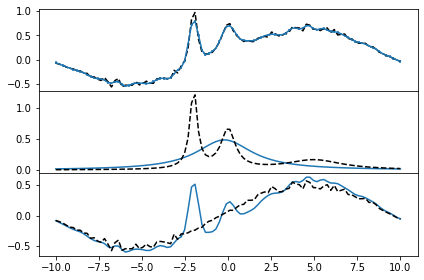

In [8]:
#Check out predictions
#Note that predict_f returns noiseless estimates, which is probably what we want
#But we also get variances in our estimates
#By default the full model is return, which is the mean function added to the rest
#We look at the full fit in the top panel, just the mean function in the middle, and just the "noise" in the bottom
#Remember, the parameters for our mean function have been changed by optimization (see above)

fig, ax = plt.subplots(3)

test_x = x_dat[:x.shape[0], :]
test_y = y_dat[:x.shape[0]]

pred_mean, pred_var = gpr.predict_f(test_x)
ax[0].errorbar(test_x[:, :1], pred_mean, yerr=np.sqrt(np.squeeze(pred_var)))
ax[0].plot(test_x[:, :1], test_y, 'k--')

ax[1].plot(test_x[:, :1], mf(test_x))
ax[1].plot(test_x[:, :1], orig_y[:x.shape[0]], 'k--')

ax[2].plot(test_x[:, :1], pred_mean - mf(test_x))
ax[2].plot(test_x[:, :1], orig_noise[:x.shape[0]], 'k--')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

In the above two cells, we can see that some things have gone wrong. Specifically, we did not have good initial guesses for the mean function parameters, and so the GPR model overcompensated by including some of these variations in the baseline/noise. The full model is in the top, the fit mean function alone in the middle, and the baseline and noise in the bottom. Black dashed lines are the reference distributions, or ground truth values, while blue is the model we fit.

We can try fitting again, but this time we will use better guesses. Note that freezing the parameters for the covariance kernel for initial optimization may help. It's all an issue with getting stuck in local minima here. By all means, try changing initial guesses and freezing any parameters you want with ```gpflow.set_trainable(gpr.kernel.variance, False)``` (but sub in gpr.\*.\* for the appropriate parmaeters) and see what happens! When the initial guesses are close enough, you can essentially exactly recover the correct mean function, baseline and noise.

In [17]:
kern = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 1.0, 1.0])
mf = MeanFunc(locs=[-2.5, 0.1, 4.5], widths=[1.0, 1.0, 4.5])
gpr = gpflow.models.GPR(data=(x_dat, y_dat), kernel=kern, mean_function=mf)

In [18]:
# gpflow.set_trainable(gpr.kernel.variance, False)
# gpflow.set_trainable(gpr.kernel.lengthscales, False)
# gpflow.set_trainable(gpr.likelihood.variance, False)
# opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=100))
# gpr

In [19]:
# gpflow.set_trainable(gpr.kernel.variance, True)
# gpflow.set_trainable(gpr.kernel.lengthscales, True)
# gpflow.set_trainable(gpr.likelihood.variance, True)
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=100))
gpr

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.locs,Parameter,Identity,,True,"(3,)",float64,[-2.00024032e+00 2.28747363e-04 4.51924381e+00]
GPR.mean_function.widths,Parameter,Softplus,,True,"(3,)",float64,[0.51375002 0.99653225 3.78581812]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.3710472128038834
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[ 6.08514577 17.249183 9.84326253]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0012552943298578228


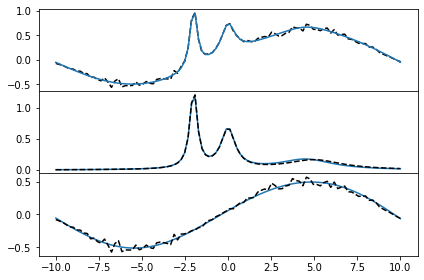

In [20]:
fig, ax = plt.subplots(3)

test_x = x_dat[:x.shape[0], :]
test_y = y_dat[:x.shape[0]]

pred_mean, pred_var = gpr.predict_f(test_x)
ax[0].errorbar(test_x[:, :1], pred_mean, yerr=np.sqrt(np.squeeze(pred_var)))
ax[0].plot(test_x[:, :1], test_y, 'k--')

ax[1].plot(test_x[:, :1], mf(test_x))
ax[1].plot(test_x[:, :1], orig_y[:x.shape[0]], 'k--')

ax[2].plot(test_x[:, :1], pred_mean - mf(test_x))
ax[2].plot(test_x[:, :1], orig_noise[:x.shape[0]], 'k--')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()